## Demonstration of radiation condition, free and fixed boundaries and dispersion

--- 1.860429048538208 seconds ---


<IPython.core.display.Javascript object>


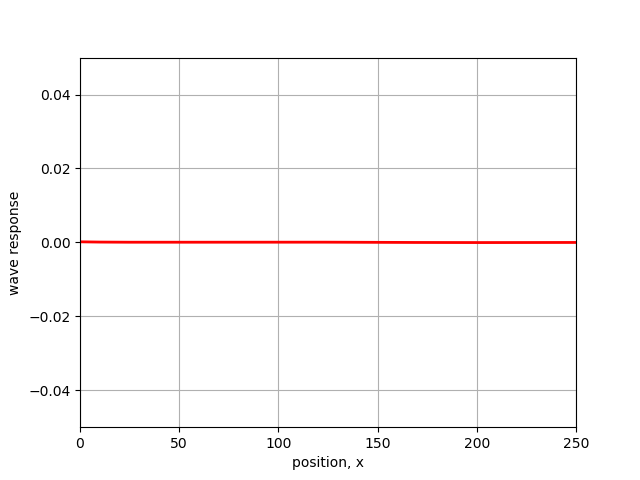

In [8]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy import integrate
from numpy.linalg import inv
%matplotlib notebook

import time
start_time = time.time()

H = 250

z  = np.linspace(0,H,500)
Le = z[1]-z[0]
        
nnode = z.shape[0]
nelem = nnode-1

vs  = 200
rho = 2000
G   = rho*vs**2
k0 = 1.95e5


dt = 0.005
f0 = 1
n  = 2000
t0 = 1

t = np.linspace(0,1,n)*dt*(n-1)

def ricker(f0,t0,t):
    tau = t-t0
    aw  = (1-2*tau*tau*f0**2*np.pi**2)*np.exp(-tau**2*np.pi**2*f0**2);
    vw  = integrate.cumtrapz(aw,t,initial=0)
    uw  = integrate.cumtrapz(vw,t,initial=0)
    return aw,vw,uw

aw,vw,uw = ricker(f0,t0,t)

K = np.zeros((nnode,nnode))
K0= np.identity(nnode)*k0
C = np.zeros((nnode,nnode))
M = np.zeros((nnode,nnode))

for j in range(nelem):
    node1 = j
    node2 = j+1
    K[node1,node1] +=  G/Le;
    K[node1,node2] += -G/Le;
    K[node2,node1] += -G/Le;
    K[node2,node2] +=  G/Le;
    M[node1,node1] +=  rho*Le/3;
    M[node1,node2] +=  rho*Le/6;
    M[node2,node1] +=  rho*Le/6;
    M[node2,node2] +=  rho*Le/3;

K += K0
#C[nnode-1,nnode-1] = rho*vs;

Kff = K[1:nnode+1,1:nnode+1]
Mff = M[1:nnode+1,1:nnode+1]
Cff = C[1:nnode+1,1:nnode+1]
Kfo = K[1:nnode+1,0]
Mfo = M[1:nnode+1,0]
Cfo = C[1:nnode+1,0]

Kfo = np.reshape(Kfo,(nnode-1,1))
Cfo = np.reshape(Cfo,(nnode-1,1))
Mfo = np.reshape(Mfo,(nnode-1,1))

gamma = 0.50
beta  = 0.25

U = np.zeros((nnode,n))
V = np.zeros((nnode,n)) 
A = np.zeros((nnode,n))
U[0,:] = uw
V[0,:] = vw
A[0,:] = aw

F =-Mfo*aw[0]-Cfo*vw[0]-Kfo*uw[0]
Mstar = Mff + gamma*dt*Cff + beta*dt**2*Kff
MstatInv = inv(Mstar)

for i in range(1,n):
    F     = -Mfo*aw[i]-Cfo*vw[i]-Kfo*uw[i]
    Uhat  = U[1:,i-1] + dt*V[1:,i-1] + (1-2*beta)/2*dt**2*A[1:,i-1]
    Vhat  = V[1:,i-1] + (1-gamma)*dt*A[1:,i-1]
    Uhat  = np.reshape(Uhat,(nnode-1,1))
    Vhat  = np.reshape(Vhat,(nnode-1,1))
    Fstar = F - np.dot(Cff,Vhat) - np.dot(Kff,Uhat)
    a = np.dot(MstatInv,Fstar)
    A[1:,i] = np.reshape(a,(nnode-1,))
    U[1:,i] = np.reshape(Uhat + beta*dt**2*a,(nnode-1,))
    V[1:,i] = np.reshape(Vhat + gamma*dt*a,(nnode-1,))
 

print("--- %s seconds ---" % (time.time() - start_time))
fig=plt.figure()
ax = plt.axes(xlim=(0,H), ylim=(-0.05, 0.05),xlabel='position, x',ylabel = 'wave response')
ax.grid()
line, = ax.plot([], [], lw=2,color='r')

def init():
    line.set_data([], [])
    return line

def animate(i):
    line.set_data(z, U[:,i])
    return line

anim = FuncAnimation(fig, animate, init_func=init,frames=2000, interval=20, blit=True)